In [5]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import time
from joblib import Parallel, delayed
from skimage.util.shape import view_as_windows
from skimage.feature import greycomatrix, greycoprops
import math 


plt.rcParams["figure.figsize"] = (18,16)
features = ["dissimilarity","contrast","correlation","energy" ]
angles= [math.radians(degree) for degree in range(0,181,1)]
img_1 = cv2.imread("./img1.jpg",0)
img_2 = cv2.imread("./img2.jpg",0)

In [26]:
plt.rcParams["figure.figsize"] = (18,16)

def GaborFilters(angles,filter_sizes,sigma,landa,gamma):
    results = []
    for filter_size in filter_sizes:
        for theta in angles:
            kernel = cv2.getGaborKernel((filter_size, filter_size), sigma, theta, landa, gamma, 0, ktype=cv2.CV_64F)
            normal_kernel = kernel / 1.0 * kernel.sum() 
            results.append(normal_kernel)
    return results

def GenerateOutput(img, filters):
    outputs = []
    for kernel in filters:
        outputs.append(cv2.filter2D(img, -1, kernel))
    return outputs


def GaborSegmentation(img, sigma, landa, gamma, filter_sizes, angles):
    start = time.time()

    img = cv2.GaussianBlur(img,(7,7),1)
    h,w = img.shape
    _filters = GaborFilters(angles,filter_sizes,sigma,landa,gamma)
    _img_filtered = GenerateOutput(img ,_filters)
    _img_filtered = np.asarray(_img_filtered)
    
    reshape_img = _img_filtered.reshape((-1,h * w))
    reshape_img = reshape_img.transpose(1,0)
    
    scaler = StandardScaler()
    scaler.fit(reshape_img)
    standard_result = scaler.transform(reshape_img)

    end = 0
    for k in [3,2]:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(standard_result)
        if k == 3 :
            end = time.time()
            duration = end - start
        else:
            tmp = time.time()
            duration = tmp - start
            duration -= tmp - end
        
        duration = round(duration,2)
        pred = kmeans.labels_
        final = pred.reshape((h,w))

        plt.rcParams["figure.figsize"] = (18,16)
        plt.subplot(2,1,1)
        plt.imshow(img,cmap="gray")
        plt.axis("off")
        plt.title("Input Image | Gaussian Blur(7x7,1)")

        plt.subplot(2,1,2)
        plt.imshow(final)
        plt.axis("off")
        plt.title("Gabor based Segmentation using K-Means | Degrees:0-180, Sigma:{0}, Lambda:{1}, Gamma:{2}, Duration:{3}s".format(sigma,landa,gamma,duration))
        
        plt.show()

    return standard_result

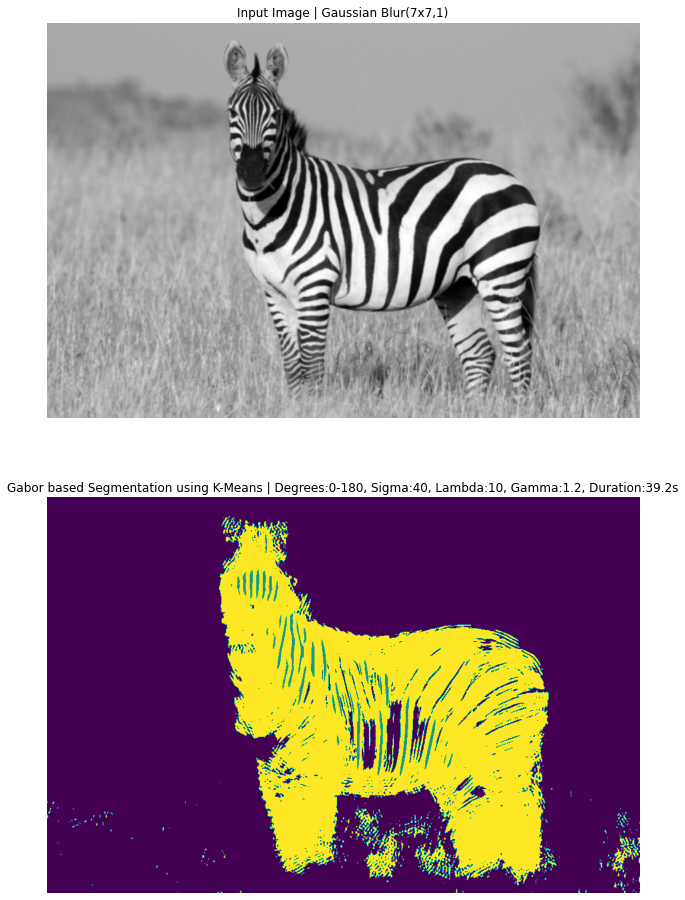

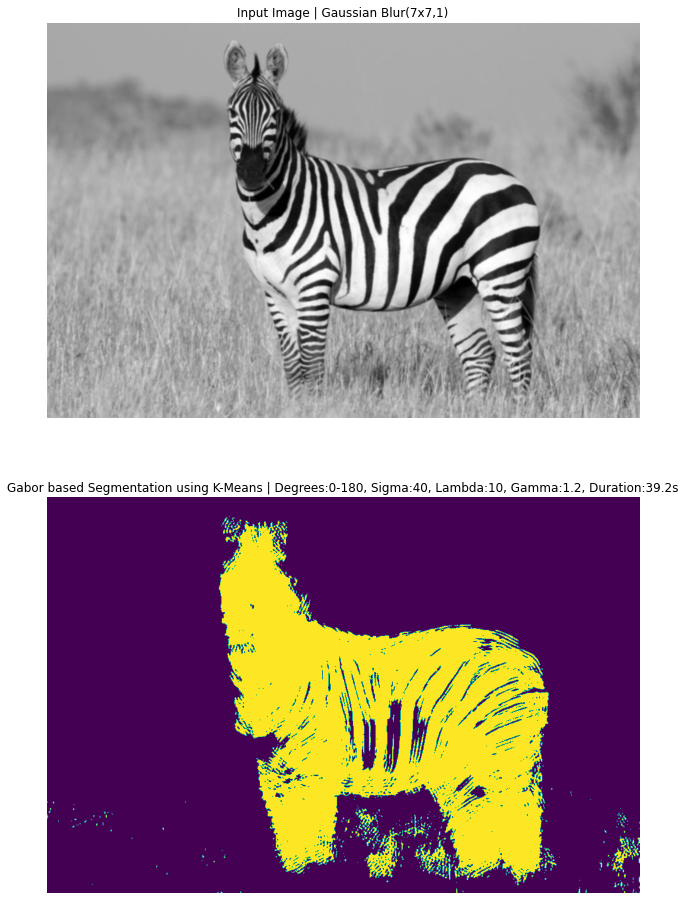

In [56]:
plt.rcParams["figure.figsize"] = (18,16)
filter_sizes = [30,35,40]
standard_result = GaborSegmentation(img_1,40,10,1.2,filter_sizes,angles)


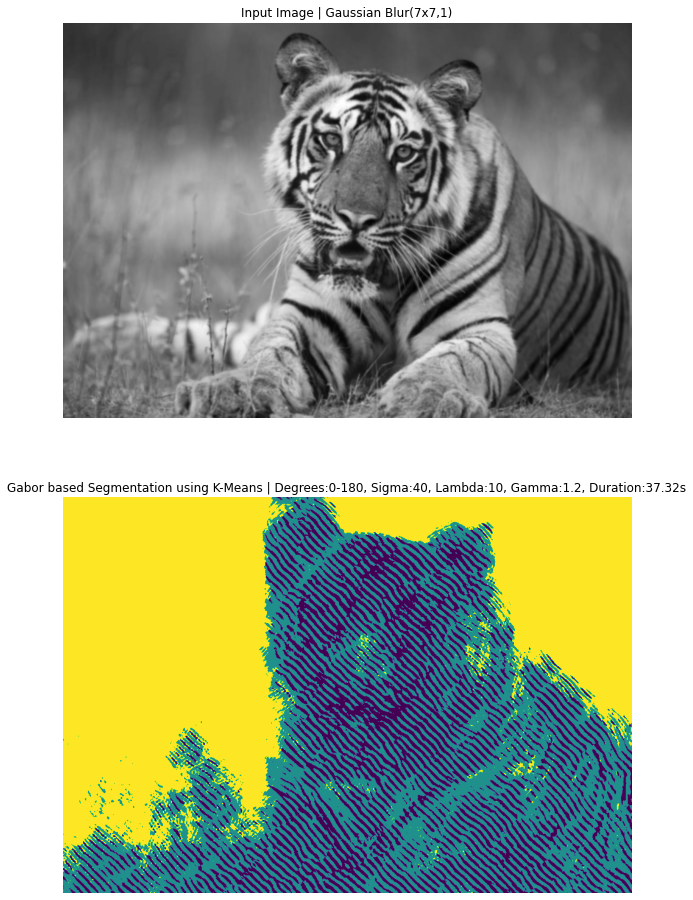

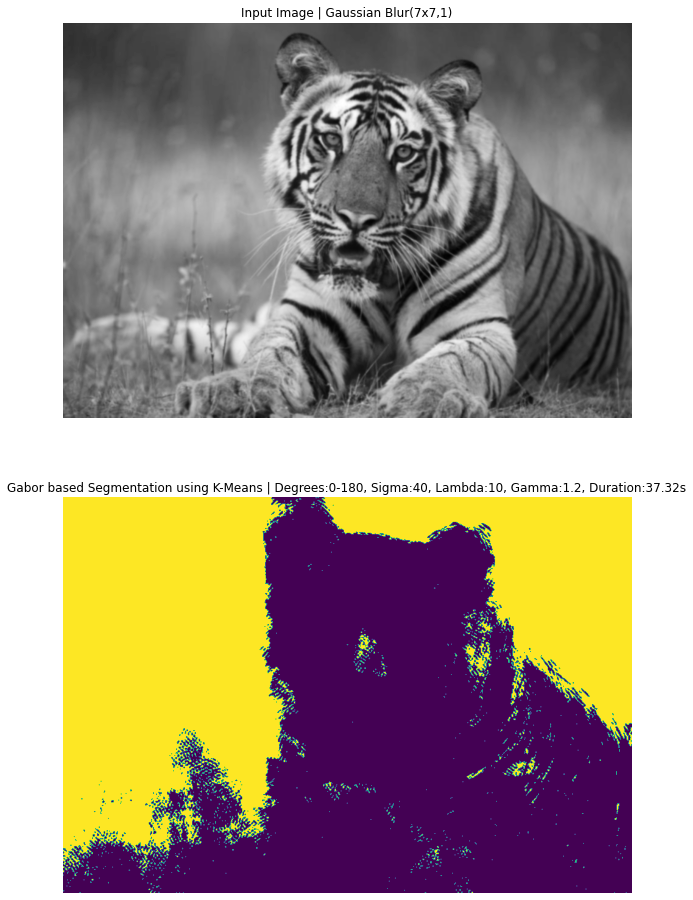

In [62]:
filter_sizes = [50,55,60]
standard_result = GaborSegmentation(img_2,40,10,1.2,filter_sizes,angles)